# MobileNetV1 Pytorch Implementation

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchsummary import summary
import matplotlib.pyplot as plt
import pickle

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading CIFAR10 Dataset

In [2]:
transforms = T.Compose([
    T.ToTensor()
])

In [3]:
cifar_train = torchvision.datasets.CIFAR10('./CIFAR/CIFAR10_train/', train=True, download=True, transform=transforms)
cifar_test = torchvision.datasets.CIFAR10('./CIFAR/CIFAR10_test/', train=False, download=True, transform=transforms)

with open("CIFAR/CIFAR10_train/cifar-10-batches-py/batches.meta", "rb") as file:
    meta = pickle.load(file)
    label_names = meta['label_names']

data_loader_train = torch.utils.data.DataLoader(cifar_train, batch_size=32, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(cifar_test, batch_size=32)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR/CIFAR10_train/cifar-10-python.tar.gz to ./CIFAR/CIFAR10_train/


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR/CIFAR10_test/cifar-10-python.tar.gz to ./CIFAR/CIFAR10_test/


In [4]:
def show_images(images, nmax=64):
    fix, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    img_grid = make_grid((images[:nmax]), nrow=8)
    ax.imshow(img_grid.permute(1, 2, 0))

airplane
ship
horse
frog
cat
truck
frog
dog
frog
deer
horse
bird
airplane
cat
horse
frog
ship
horse
frog
automobile
airplane
ship
dog
bird
dog
frog
truck
dog
bird
ship
automobile
dog


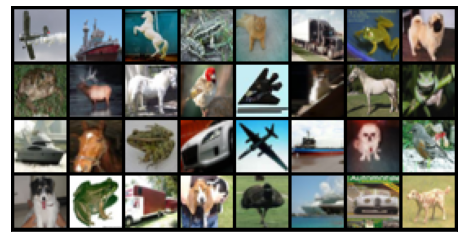

In [5]:
batch_X, batch_Y = iter(data_loader_train).next()
show_images(batch_X, 32)
print("\n".join(list(map(lambda x: label_names[x], batch_Y))))

### Model

#### Conv2d with groups parameter
`groups` controls the connection betweeen input and outputs. `in_channels` and `out_channels` must both be divisible by `groups`.

If groups=1, all inputs are convolved to all outputs.

If groups=2, the operation becomes equivalent to having two conv layers side by side, each seeing half the input channels and producing half the output channels, and both subsequently concatenated.

If groups=`in_channels`, each input channel is convolved with its own set of filters (of size `out_channels` / `in_channels`)

In [12]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        # Depthwise
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Pointwise
        self.conv2 = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

In [13]:
class MobileNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(MobileNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 32, 3, 2, 1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv_blocks = nn.Sequential(
            CNNBlock(32, 64, 1),
            CNNBlock(64, 128, 2),
            CNNBlock(128, 128, 1),
            CNNBlock(128, 256, 2),
            CNNBlock(256, 256, 1),
            CNNBlock(256, 512, 2),
            CNNBlock(512, 512, 1),
            CNNBlock(512, 512, 1),
            CNNBlock(512, 512, 1),
            CNNBlock(512, 512, 1),
            CNNBlock(512, 512, 1),
            CNNBlock(512, 1024, 2),
            CNNBlock(1024, 1024, 1)
        )
        self.aap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, n_classes)


    def forward(self, x):
        x = self.relu(self.bn(self.conv1(x)))
        x = self.conv_blocks(x)
        x = self.aap(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [14]:
model = MobileNet(in_channels=3, n_classes=10).to(device)
summary(model, input_size=(3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]           2,048
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
         CNNBlock-10           [-1, 64, 16, 16]               0
           Conv2d-11             [-1, 64, 8, 8]             576
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
           Conv2d-14            [-1, 12

### Training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [21]:
for epoch in range(2):
    print(f"Epoch: {epoch}")

    for batch_i, (X, Y) in enumerate(data_loader_train):
        X = X.to(device)
        Y = F.one_hot(Y, num_classes=10).float().to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if batch_i % 100 == 0:
            print(f"Loss: {loss.item()}")

Epoch: 0
Loss: 1.0697355270385742
Loss: 1.0719610452651978
Loss: 1.1324937343597412
Loss: 0.8741427659988403
Loss: 0.7357785105705261
Loss: 0.8192648887634277
Loss: 0.6851880550384521
Loss: 0.6682154536247253
Loss: 1.5725650787353516
Loss: 1.000720500946045
Loss: 1.062110424041748
Loss: 0.5647856593132019
Loss: 1.078450083732605
Loss: 1.134988784790039
Loss: 1.152683973312378
Loss: 0.7236610651016235
Epoch: 1
Loss: 1.192462682723999
Loss: 0.8252032995223999
Loss: 0.6370630264282227
Loss: 0.6175141930580139
Loss: 0.9327994585037231
Loss: 0.9652750492095947
Loss: 0.6730282306671143
Loss: 0.5523678064346313
Loss: 0.6083598136901855
Loss: 0.8565309047698975
Loss: 0.9081876277923584
Loss: 1.023437261581421
Loss: 0.8031681776046753
Loss: 0.7109959125518799
Loss: 0.8828216195106506
Loss: 0.6785147190093994


### Evaluation

Accuracy: 0.6668999791145325


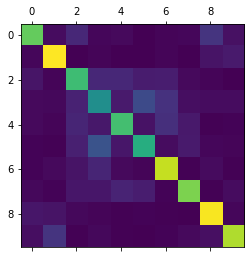

In [22]:
correct = 0
total = 0
confusion_matrix = [[0 for _ in range(10)] for _ in range(10)]

with torch.no_grad():
    for batch_i, (X, Y) in enumerate(data_loader_test):
        total += X.shape[0]

        X = X.to(device)
        Y = Y.to(device)
        outputs = torch.argmax(model(X), dim=1)
        correct += torch.sum(outputs == Y)

        for true, pred in zip(Y, outputs):
            confusion_matrix[true][pred] += 1

print(f'Accuracy: {correct / total}')
plt.matshow(confusion_matrix)